# Redes Neuronales Artificiales

Las redes neuronales artificiales (RNA) son un modelo de computación inspirado en el modelo biológico de redes neuronales.

Estos modelos pueden ser aplicados en el contexto de aprendizaje mecánico, pues permiten descubrir patrones en conjuntos de datos que abstraen algún escenario particular. Posteriormente el modelo puede aplicar estos patrones para estimar valores o clasificaciones ante nuevas observaciones del mismo escenario.

## Problema

Vamos a conocer los detalles teóricos de modelamiento de RNA a través del desarrollo de un problema particular.

Trabajaremos con un conjunto de datos para clasificación de frutas (https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/fruit_data_with_colors.txt). 

El conjunto de datos registra las medidas de masa, altura, anchura y color de 19 naranjas y 19 manzanas.

Con este conjunto de datos y nuestra RNA realizaremos una tarea de clasificación, de manera tal que la RNA aprenderá a reconocer la fruta con base en sus medidas.

In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre 

np.random.seed(42)

In [273]:
# Carga y limpieza de los datos
fruits = pd.read_csv("https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/fruit_data_with_colors.txt", sep='\t')
fruits = fruits[['fruit_name', 'mass', 'width', 'height', 'color_score']]
fruits.columns = ['label', 'masa', 'ancho', 'alto', 'color']

is_orange = fruits['label'] == 'orange'
is_apple = fruits['label'] == 'apple'
fruits = fruits[is_orange | is_apple]
fruits['clase'] = fruits['label'] == 'orange'
fruits = fruits.drop('label', axis=1)
fruits['clase'] = fruits['clase'].astype(int)

In [274]:
data = fruits
data.head()

,masa,ancho,alto,color,clase
0,192,8.4,7.3,0.55,0
1,180,8.0,6.8,0.59,0
2,176,7.4,7.2,0.60,0
8,178,7.1,7.8,0.92,0
9,172,7.4,7.0,0.89,0


In [275]:
print('Número de observaciones:', len(fruits))

Número de observaciones: 38


## Neuronas artificiales

Las RNA están compuestas de tres tipos de unidades:

+ Entradas: corresponden a los valores de entrada de las variables que modelan el problema.
+ Neuronas: se conectan a las entradas, a otras neuronas, y a las salidas a través de sinapsis modeladas como pesos numéricos. Las neuronas realizan cálculos con sus valores de entrada para producir un valor de salida. La salida a su vez puede servir de entrada para subsecuentes neuronas o unidades de salida permitiendo la estructura reticular.
+ Salidas: calculan un valor final para la RNA.

![Neurona artificial](https://docs.google.com/drawings/d/e/2PACX-1vRB4UvKVoNPh3sbnu4U1rPLgTu_u6rBTK6bt_a04aOYn70bZ7b2zheOdA7dpIP2qZTGc_E2kgYTgAP4/pub?w=384&h=280)

La susmación de actividad $s$ de una neurona se calcula sumando el producto de cada una de sus entradas $x_i$ por el correspondiente peso $p_i$ asignado a cada sinapsis.

$$
s = \sum_{i=1}^{n} x_i p_i
$$

La activación de la neurona determinará cuál será su valor de salida. Es una función de la actividad de las entradas, de manera análoga al proceso de sumación temporal y el disparo de un potencial de acción en una neurona biológica. 

### Funciones de activación

#### Sigmoide

Definiremos a la función de activación $f_{act}(s)$ como la función *sigmoide* también llamada *logística*.

$$
f_{act}(s) = \mathrm{sigmoide}(s) = \frac{1}{1+\mathrm{e}^{-s}}
$$

Para comprender el comportamiento de la función $\mathrm{sigmoide}$, recordemos algunos límites:

$$
\lim_{x \to \infty} \mathrm{e}^{-x} = 0
$$

$$
\lim_{x \to -\infty} \mathrm{e}^{-x} = \infty
$$

$$
\lim_{x \to \infty} \frac{1}{x} = 0
$$

$$
\mathrm{e}^{0} = 1
$$

De esta forma tenemos que la función  $\mathrm{sigmoide}$ se mueve en el rango $[0, 1]$ para argumentos en el rango $[-\infty, \infty]$.

In [276]:
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

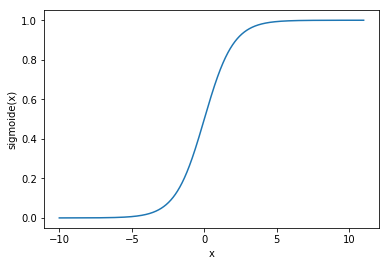

In [277]:
%matplotlib inline

x = np.arange(-10, 11, 0.01)
plt.plot(x, sigmoide(x))
plt.xlabel('x')
plt.ylabel('sigmoide(x)')
plt.show()

Otras funciones típicamente utilizadas como funciones de activación son la tangente hiperbólica $tanh(x)$ y $step(x, \Theta)$

#### Tangente hiperbólica

La función $tanh(x)$ se mueve en el rango $[-1, 1]$.

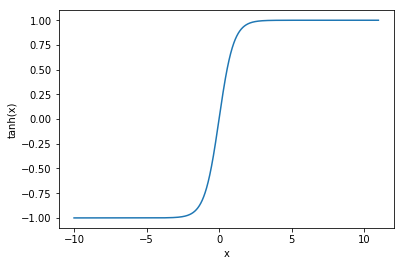

In [278]:
plt.plot(x, np.tanh(x))
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.show()

#### Función *step*

La función $step(x, \Theta)$ recibe un argumento $\Theta$ que delimita un umbral. Se define de la siguiente manera:

$$
step(x, \Theta) = 
\begin{cases}
    1, x \ge \Theta \\
    0, x < \Theta
\end{cases}
$$

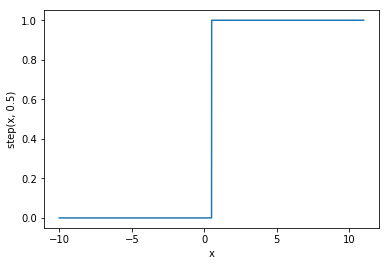

In [279]:
step = lambda x, theta: 1 if x >= theta else 0

plt.plot(x, [step(xi, theta = 0.5) for xi in x])
plt.xlabel('x')
plt.ylabel('step(x, 0.5)')
plt.show()

## Propagación hacia adelante

El algoritmo de propagación hacia adelante permite procesar las entradas, distribuyéndolas aritméticamente a través de todas las neuronas hasta finalmente producir una salida.

Supongamos la siguiente arquitectura para la RNA que nos permitirá procesar nuestro ejemplo.

![Propagación hacia adelante](https://docs.google.com/drawings/d/e/2PACX-1vSQSCKo8cHkbtuIqNW35LCczkk1qIk6qGLyFIqCWucl7CueVn2xRdRkkxGkJ2Q-pPtlpwvOzre-Jnxv/pub?w=549&h=625)

Es importante recalcar que no hay un conjunto de reglas para determinar cuál debe ser la arquitectura de nuestra RNA. Esta arquitectura se escogió por su simplicidad, sin embargo no necesariamente será la óptima para modelar nuestro problema.¿Cómo seleccionar la arquitectura óptima? El número de entradas y de salidas viene determinado por el conjunto de datos que estemos utilizando. Sin embargo no hay reglas para definir el número de capas intermedias de neuronas, ni cuántas neuronas debe contener cada capa. Estos son parámetros de la construcción de la RNA; podemos definir sus valores a partir de la experiencia, de alguna hipótesis matemática basada en nuestro entendimiento del problema y del funcionamiento de las RNA, o puede ser producto de la aplicación de algún algoritmo de optimización como *simulated annealing* o algún algoritmo genético.

Podemos representar las entradas, pesos y neuronas con matrices y de esta forma simplificar la presentación de los cálculos necesarios para realizar la propagación hacia adelante.

Supongamos el siguiente subconjunto de datos simplificado de tan solo 3 observaciones.

In [280]:
data.loc[[1,13,25]]

,masa,ancho,alto,color,clase
1,180,8.0,6.8,0.59,0
13,164,7.3,7.7,0.70,0
25,356,9.2,9.2,0.75,1


Podemos representar $X$ como la matriz de entradas $3 \times 4$, donde cada fila corresponde a una observación y cada columna a una variable del problema en el siguiente orden: `masa`, `ancho`, `alto`, `color`.

$$
X =
\begin{bmatrix}
    180 & 8.0 & 6.8 & 0.59 \\
    164 & 7.3 & 7.7 & 0.70 \\
    356 & 9.2 & 9.2 & 0.75
\end{bmatrix}
$$

En el caso de nuestro conjunto de datos completo la matriz tendría dimensiones $150 \times 4$.

Notemos que la última variable `clase` queda por fuera, pues correspondería al valor categórico $y$ que buscamos estimar.

In [281]:
X = data.loc[[1,13,25]][['masa', 'ancho', 'alto', 'color']].values

scaler = pre.MinMaxScaler()

X = scaler.fit_transform(X)
print(X)

[[ 0.08333333  0.36842105  0.          0.        ]
 [ 0.          0.          0.375       0.6875    ]
 [ 1.          1.          1.          1.        ]]


In [282]:
y = data.loc[[1,13,25]]['clase'].values.reshape(3,1)
print(y)

[[0]
 [0]
 [1]]


*Nota*: en el ejemplo anterior hicimos un paso de normalización de las entradas de $X$. Las RNA funcionan mejor cuando sus entradas están en el rango $[0, 1]$ o $[-1, 1]$. En el caso de nuestro conjunto de datos, como todas las variables corresponden a medidas de longitud podemos normalizarlas dividiendo por la máxima longitud disponible en los datos.

**Ejercicio**: ¿Porqué las RNA funcionan mejor cuando sus entradas están en el rango $[0, 1]$ o $[-1,1]$? Investigue y trabaje una posible explicación, tome en cuenta los mecanismos de sumación de actividad y la función de activación.

Los pesos de las sinapsis entre las entradas y la capa de neuronas oculta $P1$ los podemos modelar también como una matriz de dimensiones $4 \times 5$. En esta matriz cada columna representa los pesos asociados entre las entradas y la neurona correspondiente; por ejemplo, la columna $p_{13}, p_{23}, p_{33}, p_{43}$ representa los pesos para la neurona 3. De manera más detallada, el elemento $p_{13}$ representa el peso de la sinapsis entre la variable 1 de la entrada $x_1$ y la neurona 3.

$$
P1 = 
\begin{bmatrix}
    p_{11} & p_{12} & p_{13} & p_{14} & p_{15} \\
    p_{21} & p_{22} & p_{23} & p_{24} & p_{25} \\
    p_{31} & p_{32} & p_{33} & p_{34} & p_{35} \\
    p_{41} & p_{42} & p_{43} & p_{44} & p_{45}    
\end{bmatrix}
$$

Los valores para los pesos de las neuronas son inicialmente definidos aleatoriamente. Será posteriormente, en el paso de aprendizaje (propagación hacia atrás), que se calcularán los pesos finales del modelo.

In [283]:
P1 = np.random.rand(4,5)
print(P1)

[[ 0.37454012  0.95071431  0.73199394  0.59865848  0.15601864]
 [ 0.15599452  0.05808361  0.86617615  0.60111501  0.70807258]
 [ 0.02058449  0.96990985  0.83244264  0.21233911  0.18182497]
 [ 0.18340451  0.30424224  0.52475643  0.43194502  0.29122914]]


La sumación de actividad para la capa de neuronas oculta se puede definir entonces como una multiplicación de matrices.

$$
S2 = X \cdot P1 =
$$

$$
\begin{bmatrix}
    0.08  p_{11} + 0.36  p_{21} + 0.0  p_{31} + 0.0  p_{41} & \dots & \\
    \dots & \dots \\
    \dots & 1  p_{15} + 1  p_{25} + 1  p_{35} + 1  p_{45} \\
\end{bmatrix}
$$

La matriz resultante $S2$ para nuestro subconjunto de ejemplo tendrá dimensiones $3 \times 5$. Por otro lado, la matriz resultante $S2$ para el conjunto total tendría dimensiones $38 \times 5$.

Cada elemento de $S2$ representa la actividad generada por la observación en la neurona correspondiente. Por ejemplo $S2_{11}$ representa la sumación de actividad total de la observación 1 en la neurona 1; mientras que $S2_{34}$ representa la sumación de actividad total generada por la observación 3 en la neurona 4.

In [284]:
S2 = np.dot(X, P1)
print(S2)

[[ 0.08868334  0.10062542  0.38011702  0.27135163  0.2738704 ]
 [ 0.13380979  0.57288274  0.67293604  0.37658937  0.2684044 ]
 [ 0.73452364  2.28295001  2.95536916  1.84405763  1.33714533]]


Una vez calculada la sumación de actividad, necesitamos determinar si  es suficiente para que nuestras neuronas generen su valor de salida. Con este fin aplicaremos la función de activación $f_{act}$ a cada elemento de $S2$.

Recordemos que estaremos utilizando la función *sigmoide* como función de activación.

$$
f_{act}(s) = \frac{1}{1 + \mathrm{e}^{-s}}
$$

Al resultado de la aplicación de $f_{act}$ sobre $S2$ le llamaremos $A2$.

$$
A2 = f_{act}(S2) = 
\begin{bmatrix}
    f_{act}(S2_{11}) & f_{act}(S2_{12}) & f_{act}(S2_{13}) & f_{act}(S2_{14}) & f_{act}(S2_{15}) \\
    f_{act}(S2_{21}) & f_{act}(S2_{22}) & f_{act}(S2_{23}) & f_{act}(S2_{24}) & f_{act}(S2_{25}) \\
    f_{act}(S2_{31}) & f_{act}(S2_{32}) & f_{act}(S2_{33}) & f_{act}(S2_{34}) & f_{act}(S2_{35}) \\
\end{bmatrix}
$$

In [285]:
A2 = sigmoide(S2)
print(A2)

[[ 0.52215632  0.52513515  0.59390133  0.5674247   0.56804283]
 [ 0.53340262  0.63942809  0.66216027  0.59305024  0.56670114]
 [ 0.67579717  0.90745509  0.95051664  0.86342789  0.7920201 ]]


La matriz $A2$ será a su vez la entrada para calcular el valor final de la estimación de $y$ que llamaremos $ŷ$. En una RNA con más de una capa de neuronas, la salida de la capa $A2$ será su vez la entrada para la siguiente capa, produciendo al final una nueva matriz $A3$ y así sucesivamente.

Para calcular la sumación de actividad en la siguiente capa de salida recurrimos nuevamente a la multiplicación de matrices.

$$
S3 = A2 \cdot P2
$$

Recordemos que $A2$ tiene dimensiones $3 \times 5$; por otro lado $P2$ será una matriz de $5 \times 1$ representando los pesos de las sinapsis entre la capa oculta y la unidad de salida.

$$
P2 = 
\begin{bmatrix}
    p_{11} \\
    p_{21} \\
    p_{31} \\
    p_{41} \\
    p_{51}
\end{bmatrix}
$$

In [286]:
P2 = np.random.rand(5,1)
print(P2)

[[ 0.61185289]
 [ 0.13949386]
 [ 0.29214465]
 [ 0.36636184]
 [ 0.45606998]]


La matriz de sumación de actividad $S3$ tendrá entonces una dimensión $3 \times 1$. Cada elemento de la matriz representa la sumación de actividad de las 5 neuronas de la capa oculta para cada observación.

$$
S3=
\begin{bmatrix}
    A2_{11}p_{11} + A2_{12}p_{21} + A2_{13}p_{31} + A2_{14}p_{41} + A2_{15} p_{51}\\
    A2_{21}p_{11} + A2_{22}p_{21} + A2_{23}p_{31} + A2_{24}p_{41} + A2_{25} p_{51}\\
    A2_{31}p_{11} + A2_{32}p_{21} + A2_{33}p_{31} + A2_{34}p_{41} + A2_{35} p_{51}\\
\end{bmatrix}
$$

In [287]:
S3 = np.dot(A2, P2)
print(S3)

[[ 1.03319112]
 [ 1.08473317]
 [ 1.49530484]]


Finalmente calculamos la activación de $S3$ a través de la aplicación de la función de activación a cada uno de sus elementos.

$$
\hat{y} = f_{act}(S3) = 
\begin{bmatrix}
    f_{act}(S3_{11}) \\
    f_{act}(S3_{21}) \\
    f_{act}(S3_{31}) \\
\end{bmatrix}
$$

In [288]:
yhat = sigmoide(S3)
print('Estimado:')
print(yhat)
print('\nEsperado:')
print(y)

Estimado:
[[ 0.73753409]
 [ 0.74738865]
 [ 0.81687317]]

Esperado:
[[0]
 [0]
 [1]]


Las estimaciones de nuestra RNA no son particularmente buenas. De hecho son estimaciones al azar, dada la iniciación aleatoria de las matrices de pesos $P1$ y $P2$.

El aprendizaje en RNA se da a través del proceso de propagación hacia atrás, que ajusta los pesos con base en una tasa de error calculada entre la estimación $\hat{y}$ y el valor real esperado $y$.

## Propagación hacia atrás

### Tasa de error

El proceso de propagación hacia atrás requiere que definamos una función de costo, esta función cuantificará la tasa de error en las estimaciones de $\hat{y}$ con respecto al valor real esperado $y$ para cada una de nuestras observaciones.

Definiremos nuestra función de costo de la siguiente manera:

$$
f_{costo} = \sum_{i=1}^{obs} \frac{1}{2} (y_i - \hat{y}_i)^2
$$

Esta función calcula la suma total de las diferencias entre cada uno de los elementos de  la matriz $\hat{y}$ y su correspondiente valor esperado en la matriz $y$. Conforme las estimaciones sean mejores la función de costo se irá acercando a cero.

In [289]:
def fcosto(y, yhat):
    return np.sum(0.5 * (y - yhat)**2)

In [290]:
costo = fcosto(y, yhat)
print('costo:', costo)

costo: 0.568040882787


### Descenso por gradiente

El descenso por gradiente es un proceso de optimización que nos permitirá minimizar la función de costo, y por tanto minimizar el error de las estimaciones del modelo.

La función de costo depende de $y$ y de $\hat{y}$. La matriz $y$ la podemos considerar constante pues depende del conjunto de datos y no podemos manipularla. Por otro lado $\hat{y}$ es función de $X$, $P1$ y $P2$; $X$ es también parte de nuestro conjunto de datos y tampoco podemos manipularla. De esta forma, nuestra estimación es producto de los pesos de la RNA. Los pesos si podemos modificarlos en busca de mejores estimaciones.

Tenemos entonces una función de costo que es cóncava debido a su naturaleza cuadrática, y que es función tanto de P1 como P2. Nuestro objetivo es encontrar la combinación de P1 y P2 que minimicen el error.

![Descenso](https://docs.google.com/drawings/d/e/2PACX-1vRUmNGppGsuEjs4QKhtwC1hSrdNBqz36jXoKwSjsFTTQbzGYDIQMCAxKIn5tbJEnzDKKRp8Nb2Wf_tV/pub?w=960&h=720)

Recordemos que la derivada de una función permite determinar el cambio  de su valor con respecto a su variable independiente. La derivada se calcula como la pendiente de una recta tangente a la curva de la función. Utilizando la derivada de la función de costo podemos saber, para cualquier punto de la curva, si la pendiente desciende (cuando la derivada es negativa) o si la pendiente asciende (cuando es positiva). De esta forma podemos saber cómo debemos variar P1 y P2 para siempre descender hasta el mínimo global.

![Derivada](https://docs.google.com/drawings/d/e/2PACX-1vRkGj6sCMhfUxdDMIOjtLU5ryDmv7BxFydq_FQtc-0s5q9Nv7GcrQJWuXheiyok2X037voMjGtRcBAw/pub?w=467&h=287)

#### Derivada en $P2$

Debemos entonces calcular la derivada de nuestra función de costo. Recordemos que $f_{costo}$ está definida en términos tanto de $P1$ como de $P2$, por tanto debemos calcular derivadas parciales $\frac{\partial f_{costo}}{\partial P1}$ y $\frac{\partial f_{costo}}{\partial P2}$ para ajustar cada matriz de pesos de manera individual.

Empecemos por P2.

$$
\frac{\partial f_{costo}}{\partial P2} = \frac{\partial \sum_{i=1}^{obs} \frac{1}{2} (y_i - \hat{y}_i)^2}{\partial P2}
$$

Para simplificar el problema, podemos calcular la derivada para un sólo caso, y posteriormente sumar todas las derivadas valiéndonos de la regla de la suma de derivadas.

$$
\frac{\partial f_{costo}}{\partial P2} = \frac{\partial \frac{1}{2} (y - \hat{y})^2}{\partial P2}
$$

Extraemos la constante.

$$
= \frac{1}{2}  \frac{\partial  (y - \hat{y})^2}{\partial P2}
$$

Aplicamos regla de la cadena y simplificamos.

$$
= \frac{1}{2} 2 (y - \hat{y}) \frac{\partial (y - \hat{y})}{\partial P2}
$$

$$
= (y - \hat{y}) \frac{\partial (y - \hat{y})}{\partial P2}
$$

Por regla de la suma.

$$
= (y - \hat{y}) \left( \frac{\partial y}{\partial P2} - \frac{\partial \hat{y}}{\partial P2} \right)
$$

Recordemos que $y$ se mantiene constante y no cambia en términos de $P2$, entonces por la regla de la constante.

$$
= (y - \hat{y}) \left( 0 - \frac{\partial \hat{y}}{\partial P2} \right)
$$

$$
= -(y - \hat{y}) \frac{\partial \hat{y}}{\partial P2}
$$

En este punto, puesto que $\hat{y} = f_{act}(S3)$ podemos aplicar nuevamente la regla de la cadena.

$$
= -(y - \hat{y}) \frac{\partial \hat{y}}{\partial S3} \frac{\partial S3}{\partial P2}
$$


$$
= -(y - \hat{y}) \frac{\partial f_{act}(S3)}{\partial S3} \frac{\partial S3}{\partial P2}
$$


$$
= -(y - \hat{y}) f^\prime_{act}(S3) \frac{\partial S3}{\partial P2}
$$

---

Hagamos un paréntesis para determinar $f^\prime_{act}$.

$$
f_{act}(s) = \frac{1}{1+\mathrm{e}^{-s}}
$$

$$
f^\prime_{act}(s) = \frac{\mathrm{d}f_{act}(s)}{\mathrm{d}s} = \frac{\mathrm{d}}{\mathrm{d}s} \frac{1}{1+\mathrm{e}^{-s}}
$$

$$
= \frac{\mathrm{d}}{\mathrm{d}s} ({1+\mathrm{e}^{-s}})^{-1}
$$

Aplicando regla de la cadena.

$$
= -({1+\mathrm{e}^{-s}})^{-2} \frac{\mathrm{d}}{\mathrm{d}s} \left({1+\mathrm{e}^{-s}}\right)
$$

$$
= -\frac{1}{({1+\mathrm{e}^{-s}})^{2}} \frac{\mathrm{d}}{\mathrm{d}s} \left({1+\mathrm{e}^{-s}}\right)
$$

Regla de la suma.

$$
= -\frac{1}{(1+\mathrm{e}^{-s})^2} 
    \left(\frac{\mathrm{d}}{\mathrm{d}s} 1 +
    \frac{\mathrm{d}}{\mathrm{d}s} \left(\mathrm{e}^{-s}\right) \right)
$$

Regla de la constante.

$$
= -\frac{1}{(1+\mathrm{e}^{-s})^2} 
    \left(0 +
    \frac{\mathrm{d}}{\mathrm{d}s} \left(\mathrm{e}^{-s}\right) \right)
$$

$$
= -\frac{1}{(1+\mathrm{e}^{-s})^2} \frac{\mathrm{d}}{\mathrm{d}s} \mathrm{e}^{-s}
$$

Por regla de la cadena.

$$
= -\frac{1}{(1+\mathrm{e}^{-s})^2} \left( \mathrm{e}^{-s} \frac{\mathrm{d}}{\mathrm{d}s}-s \right)
$$

Sacando la constante.

$$
= -\frac{1}{(1+\mathrm{e}^{-s})^2} \mathrm{e}^{-s} \left(-\frac{\mathrm{d}}{\mathrm{d}s}s \right)
$$

$$
= -\frac{1}{(1+\mathrm{e}^{-s})^2} \mathrm{e}^{-s} \left(-1\right)
$$

Simplificando.

$$
f^\prime_{act}(s) = \frac{\mathrm{e}^{-s}}{(1+\mathrm{e}^{-s})^2}
$$


In [291]:
def sigmoidePrima(s):
    return np.exp(-s) / (1 + np.exp(-s)) ** 2

---

Volvemos ahora a la derivada parcial de nuestra función de costo en términos de $P2$.

$$
\frac{\partial f_{costo}}{\partial P2} = -(y - \hat{y}) f^\prime_{act}(S3) \frac{\partial S3}{\partial P2}
$$

Antes de resolver nuestra última derivada, recordemos que por simplicidad asumimos el supuesto de estar trabajando en una sola observación. En este punto debemos volver a tomar en cuenta la dimensionalidad de nuestras unidades. Para la primera parte de nuestra derivada parcial tenemos operaciones a nivel escalar.

$$
-(y - \hat{y}) = -1 \cdot
\begin{bmatrix}
    y_{11} \\
    y_{21} \\
    y_{31} \\
\end{bmatrix} 
-
\begin{bmatrix}
    \hat{y}_{11} \\
    \hat{y}_{21} \\
    \hat{y}_{31}
\end{bmatrix}
=
\begin{bmatrix}
    -y_{11} - \hat{y}_{11} \\
    -y_{21} - \hat{y}_{21} \\
    -y_{31} - \hat{y}_{31}
\end{bmatrix}
$$

Luego $-(y - \hat{y}) \cdot f^\prime_{act}(S3)$ es una multiplicación escalar que llamaremos $\Delta3$.

$$
\Delta3 =
\begin{bmatrix}
    -y_{11} - \hat{y}_{11} \\
    -y_{21} - \hat{y}_{21} \\
    -y_{31} - \hat{y}_{31}
\end{bmatrix}
\cdot
\begin{bmatrix}
    f^\prime_{act}(S3_{11}) \\
    f^\prime_{act}(S3_{21}) \\
    f^\prime_{act}(S3_{31})
\end{bmatrix}
=
\begin{bmatrix}
    (-y_{11} - \hat{y}_{11}) \cdot f^\prime_{act}(S3_{11}) \\
    (-y_{21} - \hat{y}_{21}) \cdot f^\prime_{act}(S3_{21}) \\
    (-y_{31} - \hat{y}_{31}) \cdot f^\prime_{act}(S3_{31}) \\
\end{bmatrix}
$$

Podemos entender a $\Delta3$ como la cuantificación del error que se propaga desde la capa de unidades de salida de vuelta hacia la capa de neuronas intermedia.

Podemos reformular entonces nuestra derivada parcial.

$$
\frac{\partial f_{costo}}{\partial P2} = \Delta3 \frac{\partial S3}{\partial P2}
$$

Y resolvemos el último término pendiente tomando en cuenta que $S3 = A2 \cdot P2$.

$$
= \Delta3 \frac{\partial A2 \cdot P2}{\partial P2}
$$

$$
= \Delta3 \cdot A2
$$

Debemos entonces multiplicar el error por la activación en la capa intermedia. Si tomamos en cuenta la dimensionalidad de $\Delta3$ $(3 \times 1)$ y $A2$ $(3 \times 5)$ notamos que para lograr esta multiplicación necesitamos transformar $A2$ en su transpuesta. 

$$
= A2^T \cdot \Delta3
$$

$$
=
\begin{bmatrix}
    A2_{11} & A2_{21} & A2_{31} \\
    A2_{12} & A2_{22} & A2_{32} \\
    A2_{13} & A2_{23} & A2_{33} \\
    A2_{14} & A2_{24} & A2_{34} \\
    A2_{15} & A2_{25} & A2_{35}
\end{bmatrix}
\cdot
\begin{bmatrix}
    \Delta3_{11} \\
    \Delta3_{21} \\
    \Delta3_{31} 
\end{bmatrix} 
=
\begin{bmatrix}
    A2_{11} \Delta3_{11} + A2_{21} \Delta3_{21} + A2_{31} \Delta3_{31} \\
    A2_{12} \Delta3_{11} + A2_{22} \Delta3_{21} + A2_{32} \Delta3_{31} \\
    A2_{13} \Delta3_{11} + A2_{23} \Delta3_{21} + A2_{33} \Delta3_{31} \\  
    A2_{14} \Delta3_{11} + A2_{24} \Delta3_{21} + A2_{34} \Delta3_{31} \\  
    A2_{15} \Delta3_{11} + A2_{25} \Delta3_{21} + A2_{35} \Delta3_{31} 
\end{bmatrix} 
$$

Notemos que de esta forma cada fila corresponde a la suma de los errores de cada observación para cada una de las neuronas de la capa oculta; la matriz resultante tendrá dimensiones $(\lvert capa\ oculta \rvert \times \lvert capa\ salida\rvert)$, es decir $5 \times 1$ para nuestro caso de ejemplo. De esta forma logramos reintroducir además la sumatoria que eliminamos en el primer paso de nuestro proceso de derivación. 

Así finalmente obtenemos la definición de nuestra derivada parcial.


$$
\frac{\partial f_{costo}}{\partial P2} = A2^T \cdot \Delta3
$$

In [292]:
Delta3 = -(y - yhat) * sigmoidePrima(S3)
print(Delta3)

[[ 0.14277005]
 [ 0.14110612]
 [-0.0273942 ]]


In [293]:
dfcosto_dP2 = np.dot(A2.T, Delta3)
print(dfcosto_dP2)

[[ 0.13130174]
 [ 0.14034178]
 [ 0.15218755]
 [ 0.14104135]
 [ 0.13936775]]


#### Derivada en $P1$

Aún tenemos pendiente resolver nuestra otra derivada parcial en términos de $P1$.

$$
\frac{\partial f_{costo}}{\partial P1} = \frac{\partial \sum_{i=1}^{obs} \frac{1}{2} (y_i - \hat{y}_i)^2}{\partial P1}
$$

Repitiendo los mismos pasos de la derivada anterior llegamos a este punto.

$$
= \Delta3 \frac{\partial S3}{\partial P1}
$$

Aplicando regla de la cadena.

$$
= \Delta3 \frac{\partial S3}{\partial A2} \frac{\partial A2}{\partial P1}
$$

Expandiendo por $S3 = A2 \cdot P2$.

$$
= \Delta3 \frac{\partial A2 \cdot P2}{\partial A2} \frac{\partial A2}{\partial P1}
$$

Tomando en cuenta la dimensionalidad de las matrices, utilizamos la transpuesta de $P2$. Otra manera de justificar la necesidad de transponer nuestras matrices implica tomar en cuenta que estamos realizando las operaciones en la dirección opuesta a la propagación hacia adelante.

$$
= \Delta3 \cdot P2^T \frac{\partial A2}{\partial P1}
$$

Expandiendo por $A2 = f_{act}(S2)$.

$$
= \Delta3 \cdot P2^T \frac{\partial f_{act}(S2)}{\partial P1}
$$

Por regla de la cadena.

$$
= \Delta3 \cdot P2^T \frac{\partial f_{act}(S2)}{\partial S2} \frac{\partial S2}{\partial P1}
$$

$$
= \Delta3 \cdot P2^T \cdot f^\prime_{act}(S2) \frac{\partial S2}{\partial P1}
$$

Expandiendo por $S2 = X \cdot P1$.

$$
= \Delta3 \cdot P2^T \cdot f^\prime_{act}(S2) \frac{\partial X \cdot P1}{\partial P1}
$$

$$
 = \Delta3 \cdot P2^T \cdot f^\prime_{act}(S2) \cdot X^T
$$

Definimos $\Delta2$.

$$
\Delta2 = \Delta3 \cdot P2^T \cdot f^\prime_{act}(S2)
$$

Y simplificamos.

$$
\frac{\partial f_{costo}}{\partial P1} = X^T \cdot \Delta2
$$

**Ejercicio**: ¿Cómo podemos generalizar estas operaciones a arquitecturas de múltiples capas ocultas?

In [294]:
Delta2 = np.dot(Delta3, P2.T) * sigmoidePrima(S2)
print(Delta2)

[[ 0.02179568  0.0049663   0.0100596   0.01283859  0.01597682]
 [ 0.02148772  0.00453821  0.00922184  0.01247637  0.01580225]
 [-0.00367231 -0.00032092 -0.00037642 -0.00118347 -0.00205801]]


In [295]:
dfcosto_dP1 = np.dot(X.T, Delta2)
print(dfcosto_dP1)

[[ -1.85599842e-03   9.29426616e-05   4.61877958e-04  -1.13586728e-04
   -7.26609154e-04]
 [  4.35768344e-03   1.50877496e-03   3.32974763e-03   3.54653728e-03
    3.82818620e-03]
 [  4.38558922e-03   1.38091261e-03   3.08176798e-03   3.49517104e-03
    3.86783359e-03]
 [  1.11005014e-02   2.79910313e-03   5.96359330e-03   7.39403784e-03
    8.80603731e-03]]


### Propagación hacia atrás

Las derivadas que recién calculamos nos permiten conocer cuál dirección es "cuesta arriba".

Notemos que $\frac{\partial f_{costo}}{\partial P2}$ tiene dimensiones $5 \times 1$ igual que $P2$; de la misma forma $\frac{\partial f_{costo}}{\partial P1}$ tiene dimensiones $4 \times 5$ igual que $P1$. 

Si tomamos en cuenta también que las derivadas representan la pendiente de una tangente, si las multiplicamos por un escalar podemos definir un vector lineal que represente movimiento (hacia arriba o hacia abajo) en la curva cóncava de la función de costo. Llamaremos a este escalar $\alpha$ y lo interpretaremos como el factor de velocidad de aprendizaje. Este es un hiperparámetro más de la RNA, un $\alpha$ muy pequeño producirá desplazamientos pequeños hacia el mínimo global, mientras que un $\alpha$ muy grande podría provocar que nos "brinquemos" el mínimo global.

Podemos entonces ajustar los pesos sumando o restando los vectores de movimiento a las matrices de pesos.

$$
P1 \leftarrow P1 \pm \alpha \frac{\partial f_{costo}}{\partial P1}
$$

$$
P2 \leftarrow P2 \pm \alpha \frac{\partial f_{costo}}{\partial P2}
$$



Ajustemos los pesos de la RNA y verifiquemos cómo varía la función de costo.

Si modificamos los pesos sumando el valor de las derivadas, el costo debería aumentar, pues nos movemos cuesta arriba, alejándonos del mínimo global.

In [296]:
# modificamos los pesos para alejarnos del mínimo global
alpha = 3
nuevo_P1 = P1 + alpha * dfcosto_dP1
nuevo_P2 = P2 + alpha * dfcosto_dP2

# propagación hacia adelante
nuevo_yhat = sigmoide(np.dot(sigmoide(np.dot(X, nuevo_P1)), nuevo_P2))
nuevo_costo = fcosto(y, nuevo_yhat)

print('costo original: ', costo)
print('nuevo costo:', nuevo_costo)

costo original:  0.568040882787
nuevo costo: 0.825250822036


Por otro lado, si modificamos los pesos **restando** el valor de las derivadas, el costo se reduce reflejando un acercamiento hacia el mínimo global.

In [297]:
# modificamos los pesos para acercarnos al mínimo global
alpha = 3
nuevo_P1 = P1 - alpha * dfcosto_dP1
nuevo_P2 = P2 - alpha * dfcosto_dP2

# propagación hacia adelante
nuevo_yhat = sigmoide(np.dot(sigmoide(np.dot(X, nuevo_P1)), nuevo_P2))
nuevo_costo = fcosto(y, nuevo_yhat)

print('costo original: ', costo)
print('nuevo costo:', nuevo_costo)

costo original:  0.568040882787
nuevo costo: 0.37379148423


Nuestras predicciones $\hat{y}$ deberían mejorar con respecto a nuestro primer intento, más bien aleatorio, que desarrollamos en la sección de propagación hacia adelante.

In [298]:
print(y)

[[0]
 [0]
 [1]]


In [299]:
# intento aleatorio
print(yhat)

[[ 0.73753409]
 [ 0.74738865]
 [ 0.81687317]]


In [300]:
# intento después de un paso de descenso por gradiente
print(nuevo_yhat)

[[ 0.46448992]
 [ 0.45383592]
 [ 0.4291541 ]]


Podemos notar que los dos primeros elementos de la nueva estimación se acercan más al valor esperado $0$. Sin embargo, el tercer elemento más bien se alejó de su valor esperado $1$.

Debemos tener presente que tan sólo realizamos un paso de descenso en gradiente. Si continuamos calculando pasos de descenso deberíamos ir obteniendo cada vez mejores estimaciones.

Por esta razón, el entrenamiento de una RNA consiste en realizar repetidamente pasos de (1) estimación (con propagación hacia adelante) y (2) de ajuste (con propagación hacia atrás); ya sea a través de un número determinado de iteraciones, o hasta que haya una convergencia -repitiendo hasta que la función de costo deje de disminuir-.


## Conclusiones

Modelamos entonces el concepto de RNA a través de elementos de álgebra lineal: matrices y vectores.

Definimos la función de activación como la función $\mathrm{sigmoide}$.

$$
f_{act}(s) = \mathrm{sigmoide}(s) = \frac{1}{1+\mathrm{e}^{-s}}
$$

Aunque también es común utilizar $\mathrm{tanh}$ y $\mathrm{step}$.

Definimos el proceso de *propagación hacia adelante*, que permite calcular estimaciones $\hat{y}$ para las salidas esperadas $y$ con base en las entradas $X$, con las siguientes ecuaciones:

Sumación de actividad en capa oculta:
$$
S2 = X \cdot P1
$$

Activación en capa oculta:
$$
A2 = f_{act}(S2)
$$

Sumación de actividad en capa de salida:
$$
S3 = A2 \cdot P2
$$

Activación y estimación final en capa de salida:
$$
\hat{y} = f_{act}(S3) = f_{act}(f_{act}(X \cdot P1) \cdot P2)
$$

Para el proceso de *propagación hacia atrás*, que permite ajustar las matrices de pesos $P1$ y $P2$ para mejorar las estimaciones, definimos la función de costo como una medida del error en las estimaciones $\hat{y}$.

$$
f_{costo} = \sum_{i=1}^{obs} \frac{1}{2} (y_i - \hat{y}_i)^2
$$

Esta función será minimizada a través de un proceso de descenso por gradiente. Este proceso requiere desarrollar derivadas parciales de la función de costo en términos de cada una de las matrices de pesos en la RNA.

Derivada de la función de activación:
$$
f^\prime_{act}(s) = \frac{\mathrm{e}^{-s}}{(1+\mathrm{e}^{-s})^2}
$$

Propagación del error desde la capa de salida a la capa oculta:
$$
\Delta3 = -(y - \hat{y}) \cdot f^\prime_{act}(S3)
$$

Derivada para pesos entre capa oculta y capa de salida:
$$
\frac{\partial f_{costo}}{\partial P2} = A2^T \cdot \Delta3
$$

Propagación del error desde la capa oculta a la capa de entradas:
$$
\Delta2 = \Delta3 \cdot P2^T \cdot f^\prime_{act}(S2)
$$

Derivada para pesos entre capa de entrada y capa oculta:
$$
\frac{\partial f_{costo}}{\partial P1} = X^T \cdot \Delta2
$$

Finalmente, las derivadas de la función de costo se utilizan para ir ajustando los pesos en un proceso iterativo de descenso hasta un mínimo global. 

Ajuste de pesos $P1$:
$$
P1 \leftarrow P1 \pm \alpha \frac{\partial f_{costo}}{\partial P1}
$$

Ajuste de pesos $P2$:
$$
P2 \leftarrow P2 \pm \alpha \frac{\partial f_{costo}}{\partial P2}
$$

**Ejercicio**: Implemente una clase en Python que modele una RNA, debe implementar una interfaz pública que contenga los métodos `entrenar()` y `predecir(nuevo_X)`. El método `predecir(nuevo_X)` recibe una matriz de valores de entrada y produce una matriz de estimaciones de salida $\hat{y}$. Su clase además debe implementar métodos privados `_prop_adelante(X)` y `_prop_atras(X, y)`. Finalmente, su clase debe permitir cualquier arquitectura de RNA, es decir el número de capas ocultas y cuántas neuronas por capa oculta debe ser parametrizable. El número de entradas y salidas se definen a partir de las dimensiones de `X` y `y`; tanto la matriz de entradas `X` como la de salidas esperadas `y` son parámetros del constructor. Finalmente, el constructor también debe tomar en cuenta otros hiperparámetros como la velocidad de aprendizaje `alfa` y el número máximo de iteraciones para el entrenamiento `iter`.

## Bibliografía

Harrington, P. (2012). Machine Learning in Action. Manning: NY

Li, S. (2017). Solving A Simple Classification Problem with Python — Fruits Lovers’ Edition. Disponible en: https://towardsdatascience.com/solving-a-simple-classification-problem-with-python-fruits-lovers-edition-d20ab6b071d2

Méndez, H. (2013). Cálculo diferencial. EUNED: San José.

Rojas, R. (1996). Neural Networks: A Systematic Introduction. Springer-Verlag: Berlin 

Welch Labs (N.D.). Neural Networks Demystified. Disponible en: https://www.youtube.com/playlist?list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU

